In [1]:
import torch.nn as nn
import torch.nn.functional as F

class no_dropout(nn.Module):

    def __init__(self, hidden_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)

    def forward(self, input):

        output = F.relu(self.linear_1(input))
        output = F.relu(self.linear_2(output))
        output = self.linear_3(output)
        return output

In [2]:
class with_dropout(nn.Module):

    def __init__(self, hidden_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input):

        output = F.relu(self.dropout(self.linear_1(input)))
        output = F.relu(self.dropout(self.linear_2(output)))
        output = self.linear_3(output)
        return output

In [3]:
from fbm_dropout.fbm_dropout import fbm_dropout

class with_fbm_dropout(nn.Module):

    def __init__(self, hidden_size, n_fibers, max_epochs):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        self.dropout_1 = fbm_dropout(0.9, n_fibers, max_epochs, hidden_size)
        self.dropout_2 = fbm_dropout(0.9, n_fibers, max_epochs, hidden_size)

    def forward(self, input, current_epoch):
        
        if self.training:
            output = F.relu(self.dropout_1(self.linear_1(input), current_epoch))
            output = F.relu(self.dropout_2(self.linear_2(output), current_epoch))
        else:
            output = F.relu(self.linear_1(input))
            output = F.relu(self.linear_2(output))
        output = self.linear_3(output)
        return output

In [4]:
import torch

N = 50
noise = 0.3

# X ranges from -1 to 1
# Y = X + gaussian noise
X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1) 
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

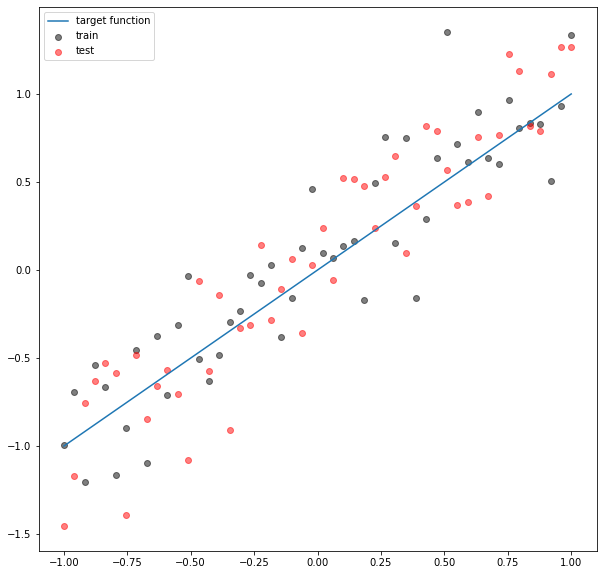

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='black', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='red', alpha=0.5, label='test')
plt.plot(X_test.data.numpy(), X_test.data.numpy(), label='target function')
plt.legend()
plt.show()

In [6]:
hidden_size = 100
max_epochs = 1000

# define three models: no dropout, dropout, fbm dropout
no_dropout_model = no_dropout(hidden_size)
with_dropout_model = with_dropout(hidden_size)
with_fbm_dropout_model = with_fbm_dropout(hidden_size, 50, max_epochs)

In [7]:
# three optimizers for three models
no_dropout_opt = torch.optim.Adam(no_dropout_model.parameters(), lr=0.01)
with_dropout_opt = torch.optim.Adam(with_dropout_model.parameters(), lr=0.01)
with_fbm_dropout_opt = torch.optim.Adam(with_fbm_dropout_model.parameters(), lr=0.01)
# same loss function
loss_fn = torch.nn.MSELoss()

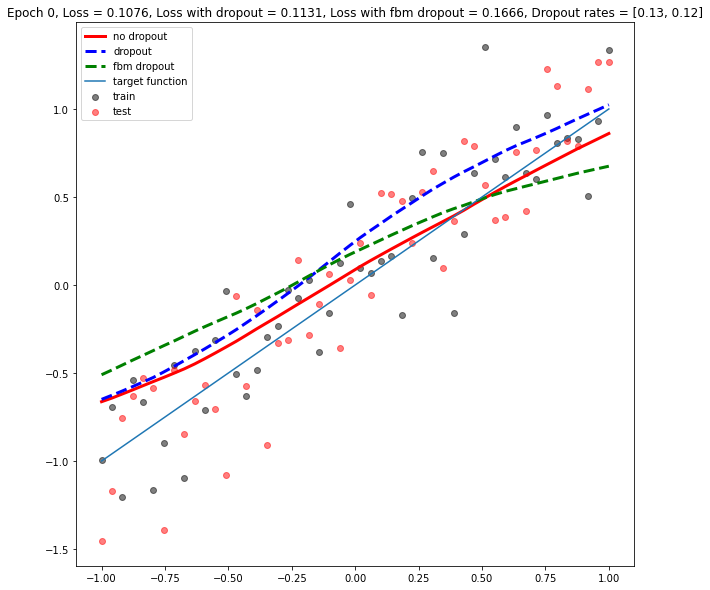

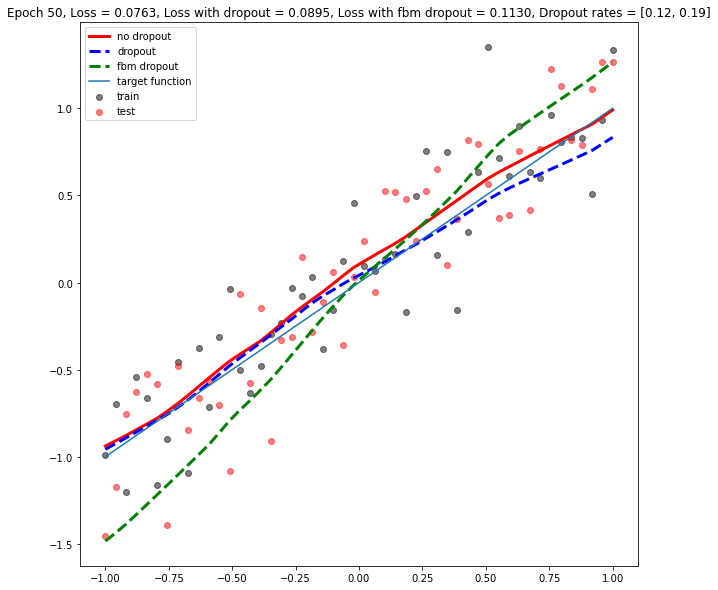

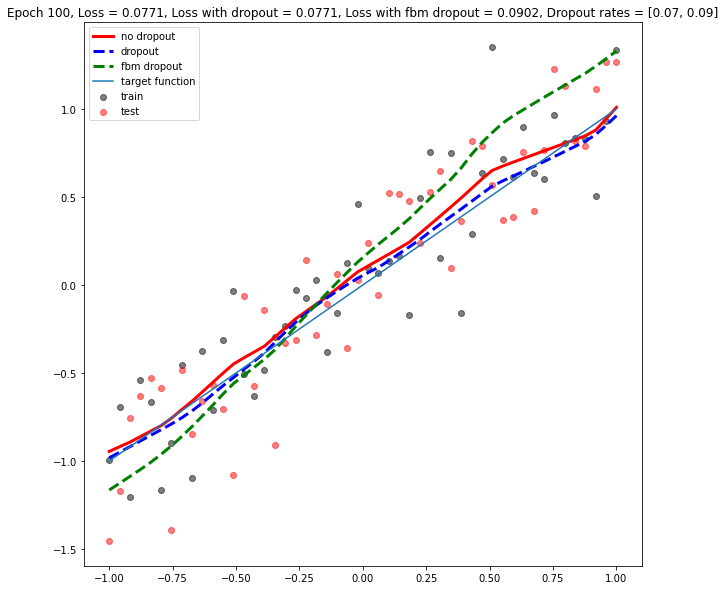

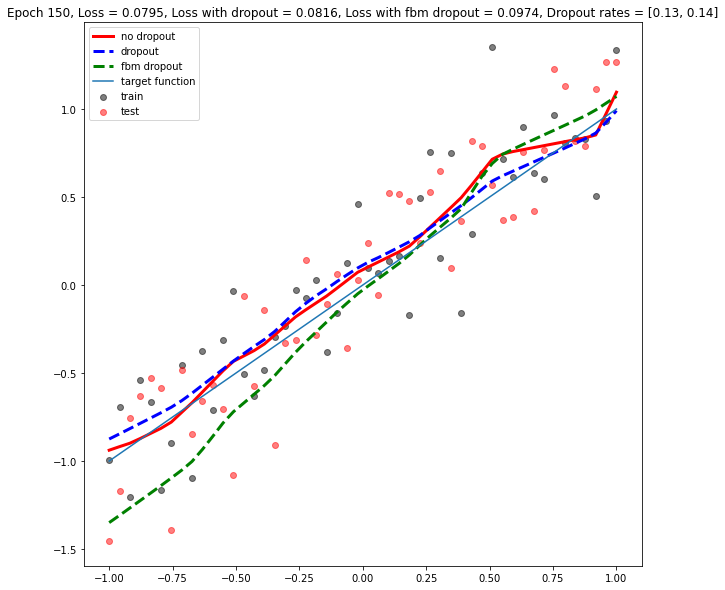

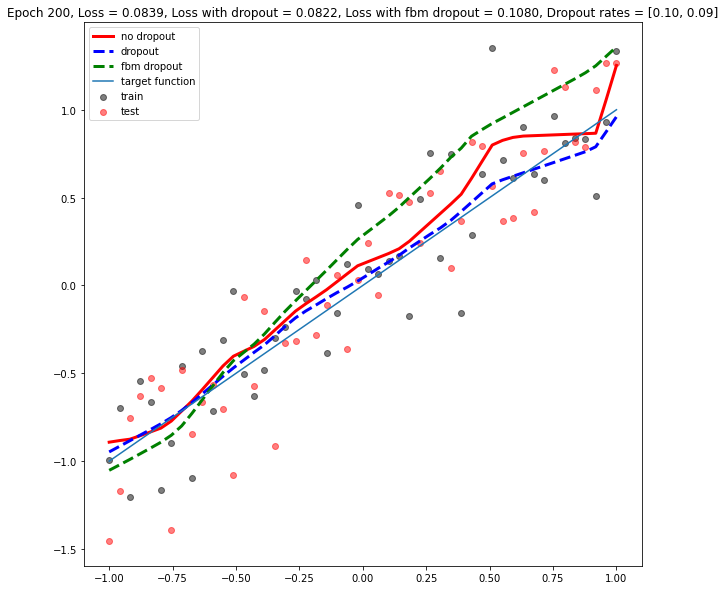

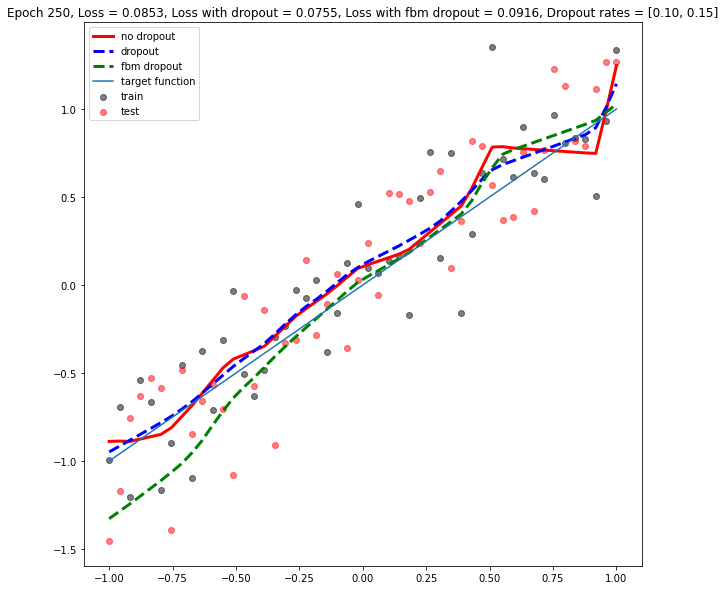

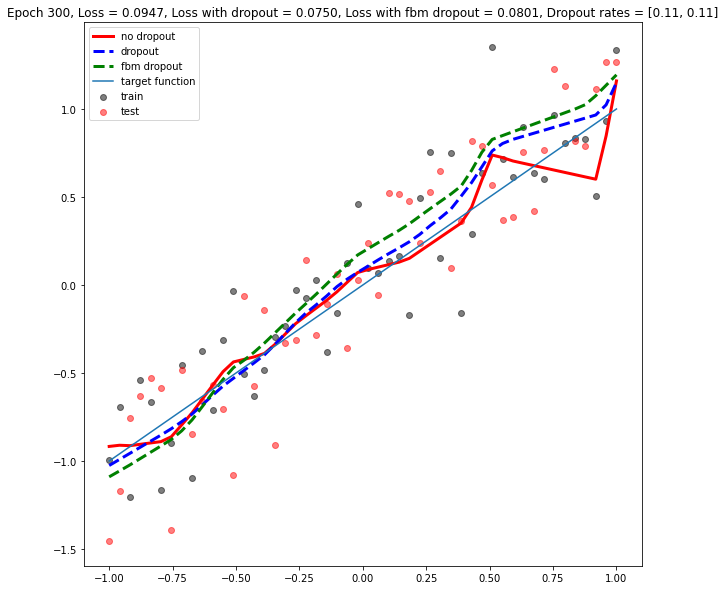

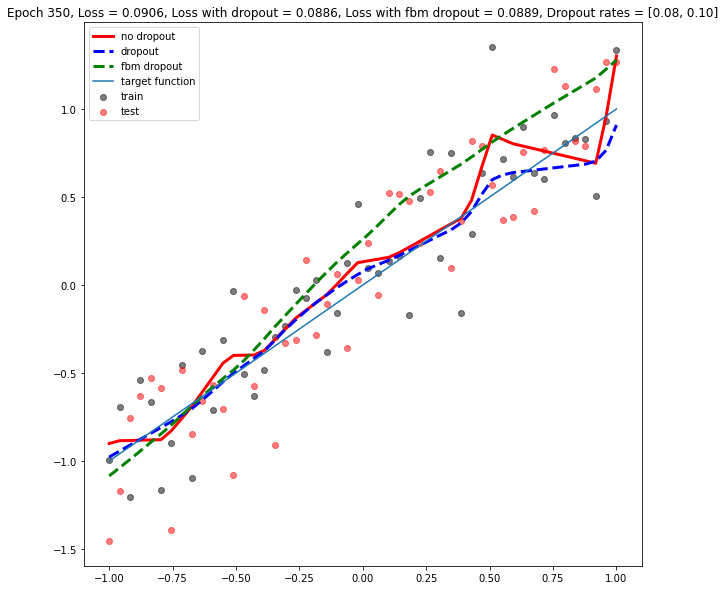

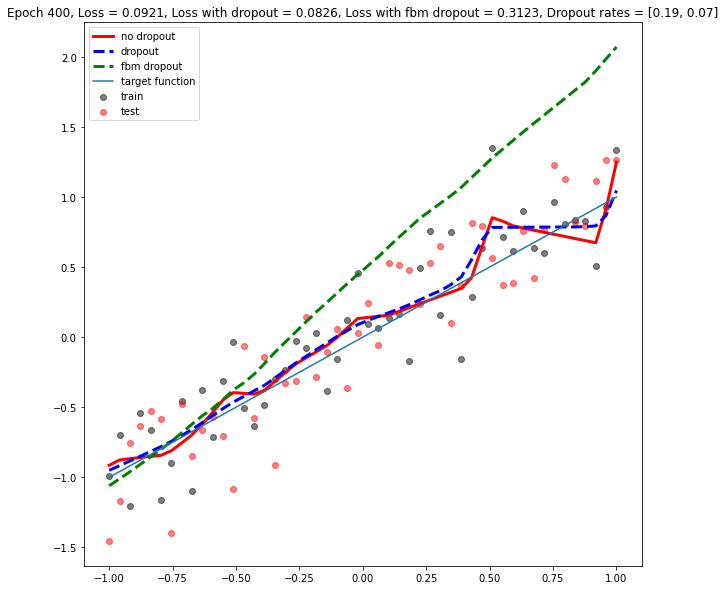

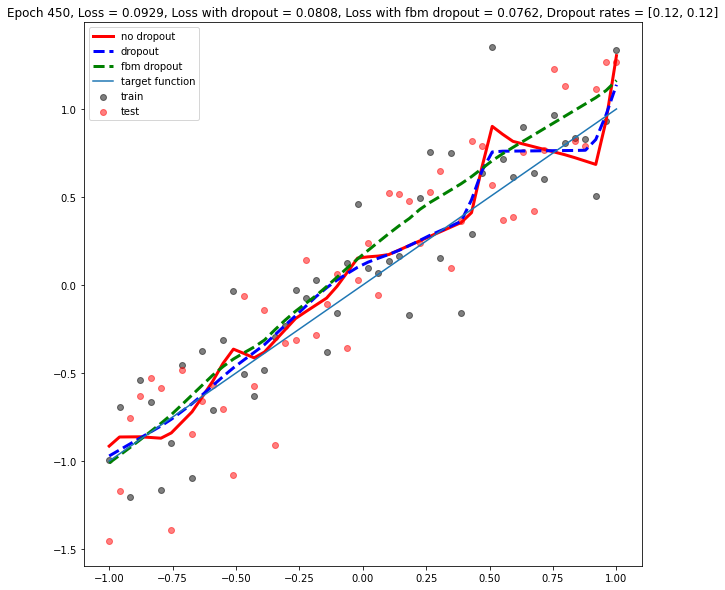

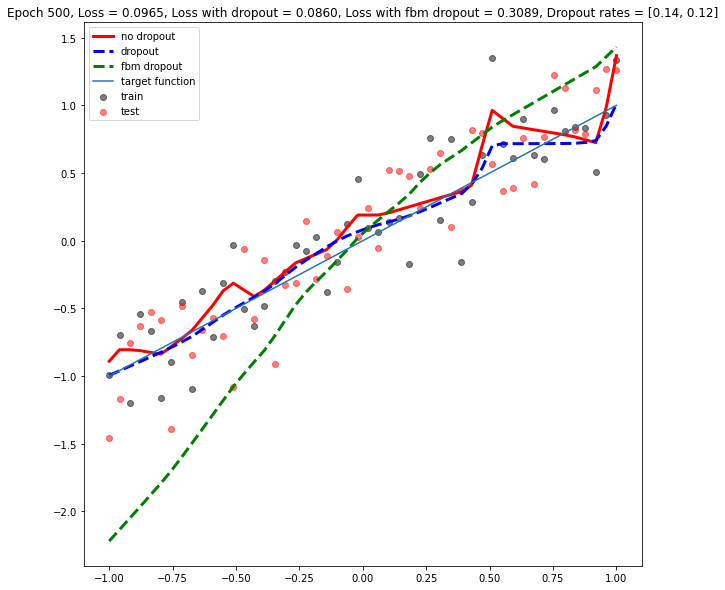

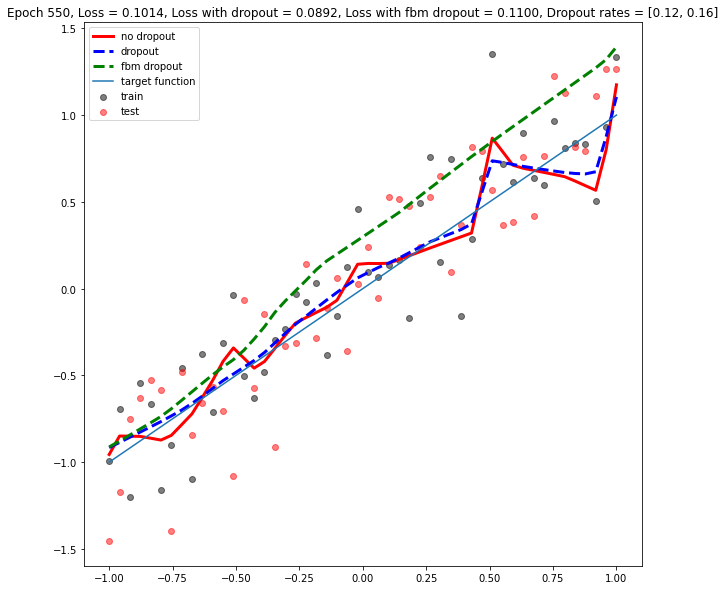

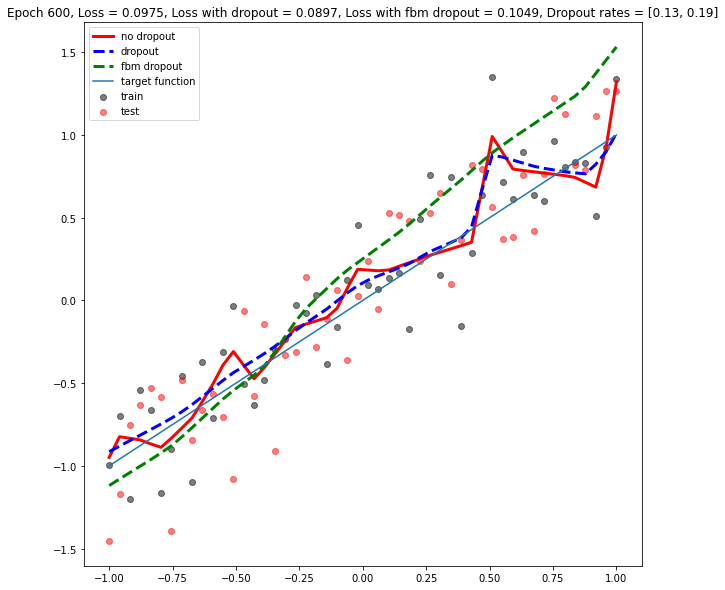

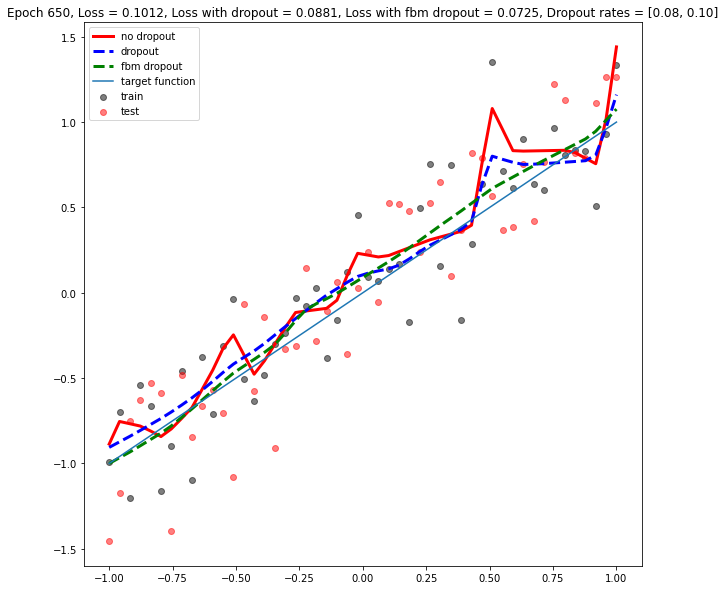

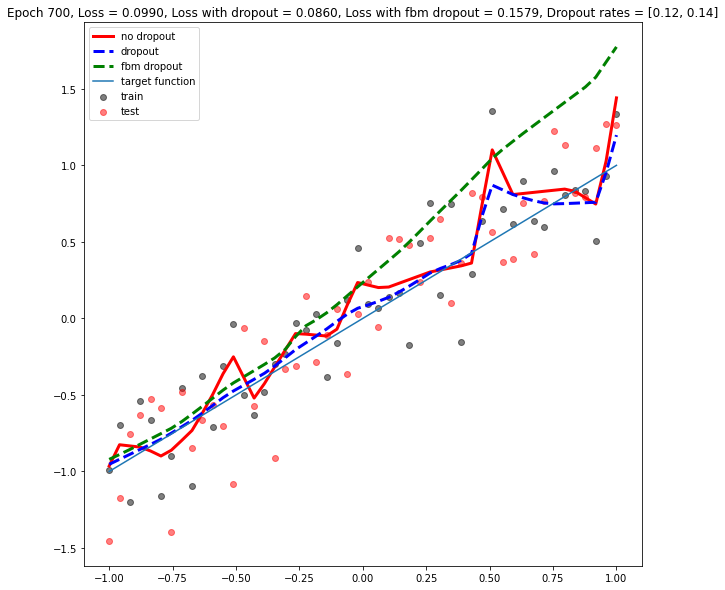

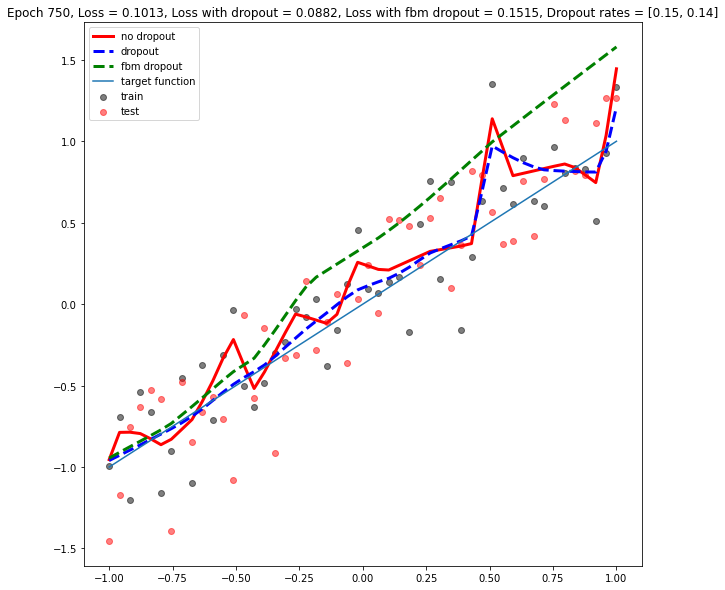

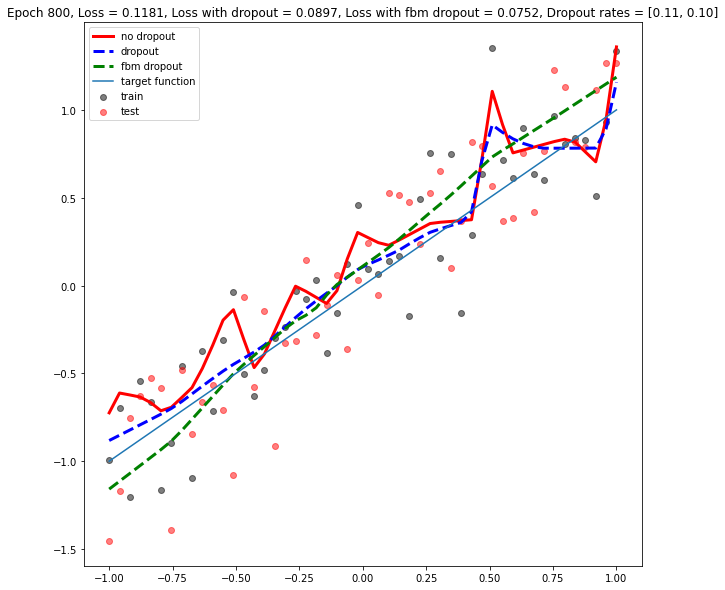

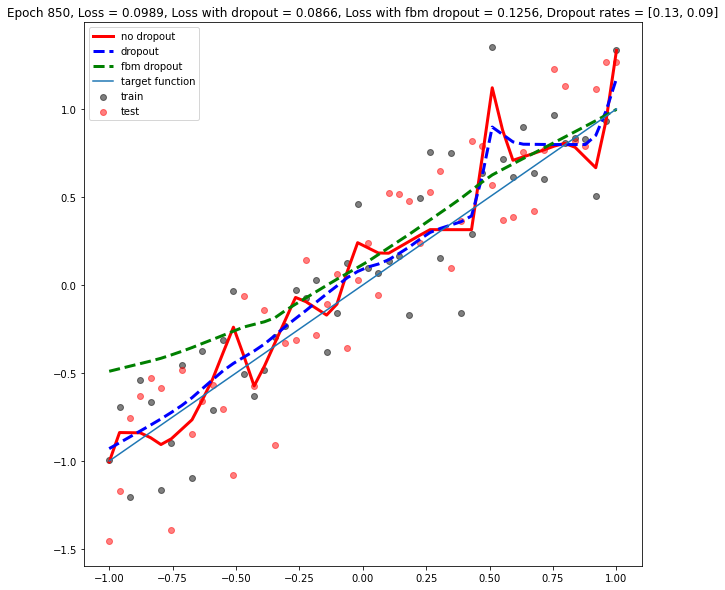

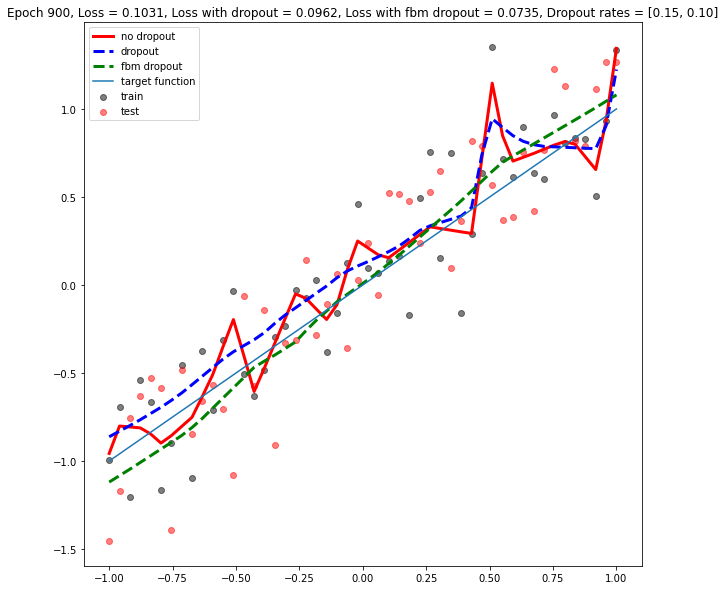

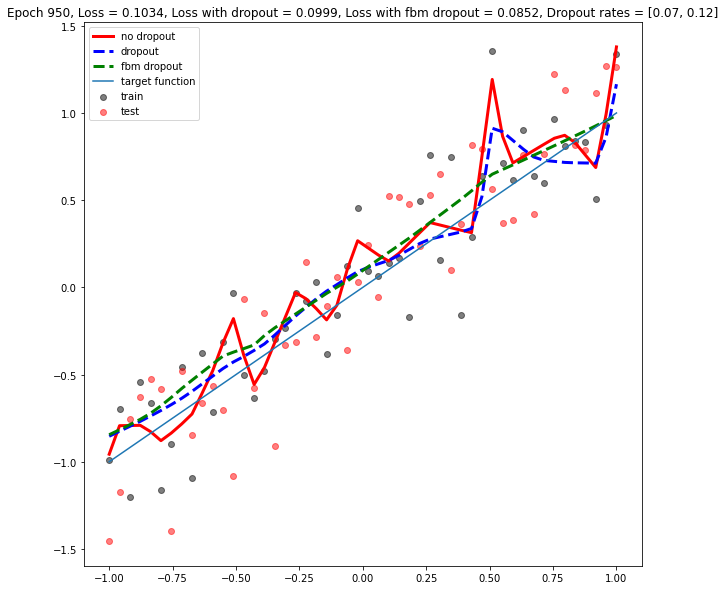

Dropout rates = [0.12, 0.12]


In [8]:
total_dr_1 = total_dr_2 = 0.0

# train
for epoch in range(max_epochs):
    
    pred = no_dropout_model(X_train) # look at the entire data in a single shot
    loss = loss_fn(pred, Y_train)
    no_dropout_opt.zero_grad()
    loss.backward()
    no_dropout_opt.step()
    
    pred_dropout = with_dropout_model(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    with_dropout_opt.zero_grad()
    loss_dropout.backward()
    with_dropout_opt.step()

    pred_fbm_dropout = with_fbm_dropout_model(X_train, epoch)
    loss_fbm_dropout = loss_fn(pred_fbm_dropout, Y_train)
    with_fbm_dropout_opt.zero_grad()
    loss_fbm_dropout.backward()
    with_fbm_dropout_opt.step()
    
    dr1 = with_fbm_dropout_model.dropout_1.get_dropout_rate()
    dr2 = with_fbm_dropout_model.dropout_2.get_dropout_rate()

    total_dr_1 += dr1
    total_dr_2 += dr2

    if epoch % 50 == 0:
        
        # test
        no_dropout_model.eval()
        with_dropout_model.eval()
        with_fbm_dropout_model.eval()
        
        test_pred = no_dropout_model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = with_dropout_model(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

        test_pred_fbm_dropout = with_fbm_dropout_model(X_test, epoch)
        test_loss_fbm_dropout = loss_fn(test_pred_fbm_dropout, Y_test)
        
        plt.figure(figsize=(10,10))
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='black', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='red', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='no dropout')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        plt.plot(X_test.data.numpy(), test_pred_fbm_dropout.data.numpy(), 'g--', lw=3,  label='fbm dropout')
        plt.plot(X_test.data.numpy(), X_test.data.numpy(), label='target function')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f, Loss with fbm dropout = %0.4f, Dropout rates = [%0.2f, %0.2f]' % (epoch, test_loss, test_loss_dropout, test_loss_fbm_dropout, dr1, dr2))
        
        plt.legend()

        no_dropout_model.train()
        with_dropout_model.train()
        with_fbm_dropout_model.train()
        
        plt.pause(0.05)

total_dr_1 /= max_epochs
total_dr_2 /= max_epochs

print('Dropout rates = [{:.2}, {:.2}]'.format(total_dr_1, total_dr_2))

In [9]:
from fbm_dropout.fbm_dropout import fbm_dropout_2

class with_fbm_dropout_2(nn.Module):

    def __init__(self, hidden_size, n_fibers, max_epochs, grid_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        self.dropout_1 = fbm_dropout_2(0.9, n_fibers, max_epochs, grid_size)
        self.dropout_2 = fbm_dropout_2(0.9, n_fibers, max_epochs, grid_size)

    def forward(self, input, current_epoch):

        if self.training:
            output = F.relu(self.dropout_1(self.linear_1(input), current_epoch))
            output = F.relu(self.dropout_2(self.linear_2(output), current_epoch))
        else:
            output = F.relu(self.linear_1(input))
            output = F.relu(self.linear_2(output))

        output = self.linear_3(output)
        return output

In [10]:
hidden_size = 100
max_epochs = 1000

no_dropout_model = no_dropout(hidden_size)
with_dropout_model = with_dropout(hidden_size)
with_fbm_dropout_model = with_fbm_dropout_2(hidden_size, 60, max_epochs, (10, 10))

In [11]:
no_dropout_opt = torch.optim.Adam(no_dropout_model.parameters(), lr=0.01)
with_dropout_opt = torch.optim.Adam(with_dropout_model.parameters(), lr=0.01)
with_fbm_dropout_opt = torch.optim.Adam(with_fbm_dropout_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

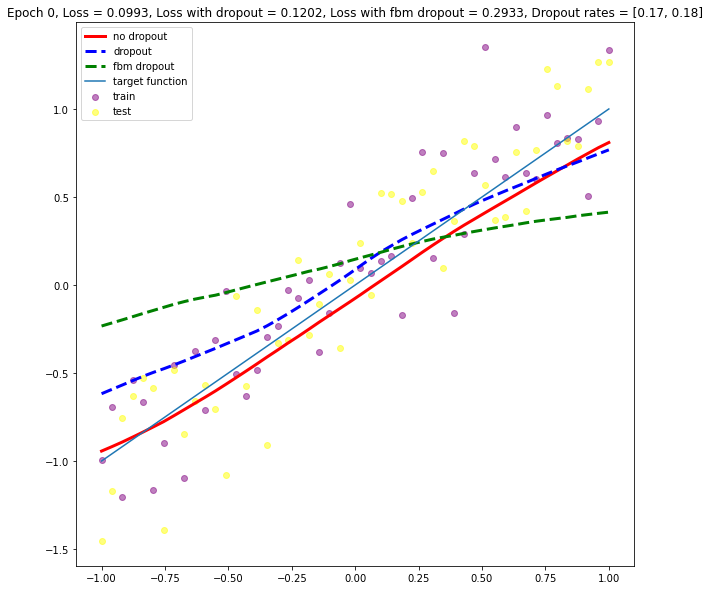

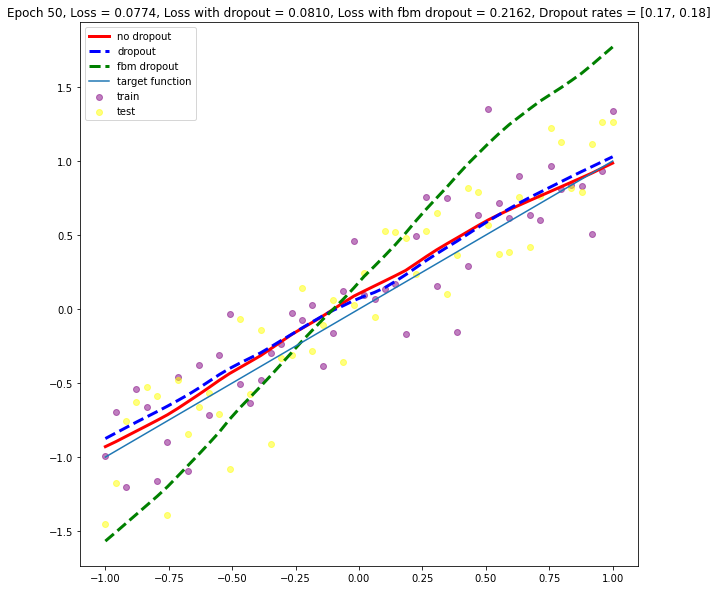

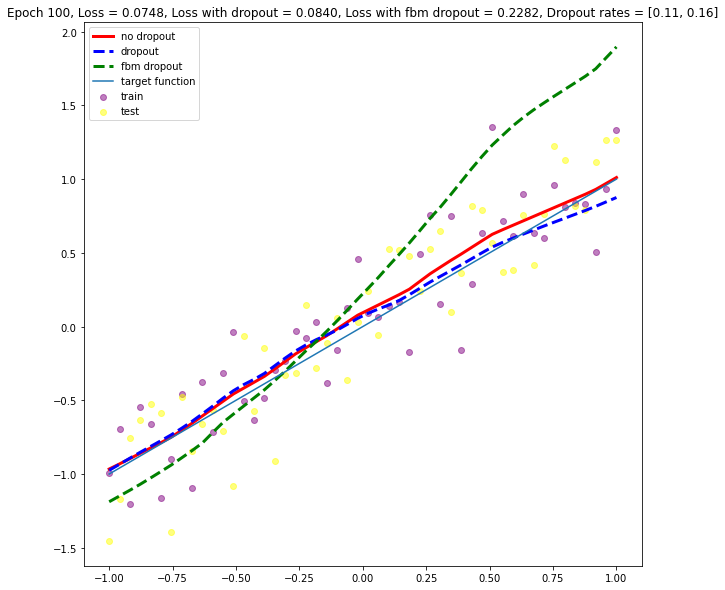

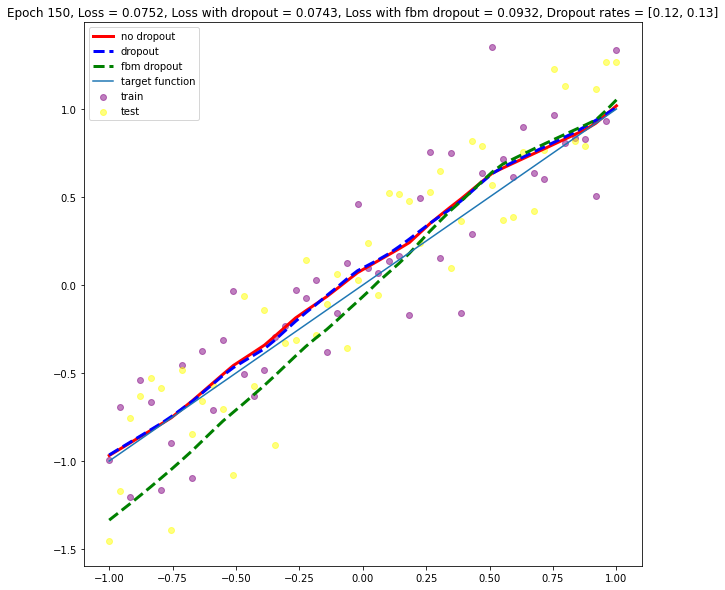

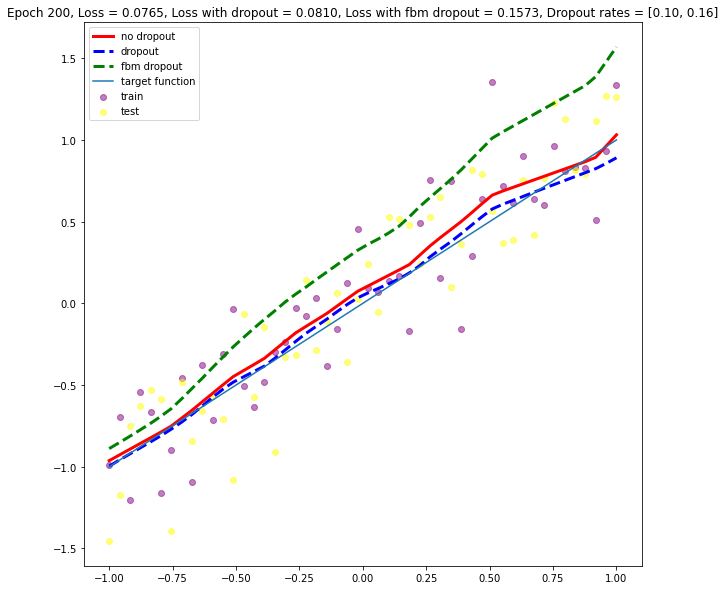

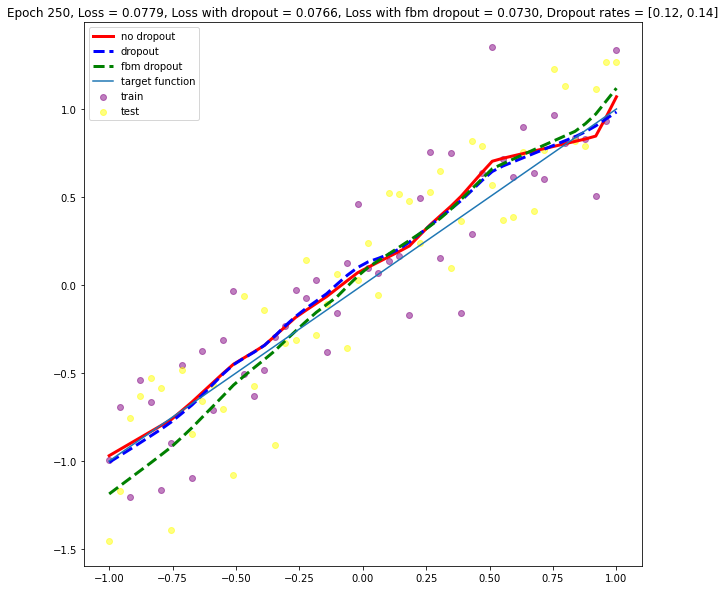

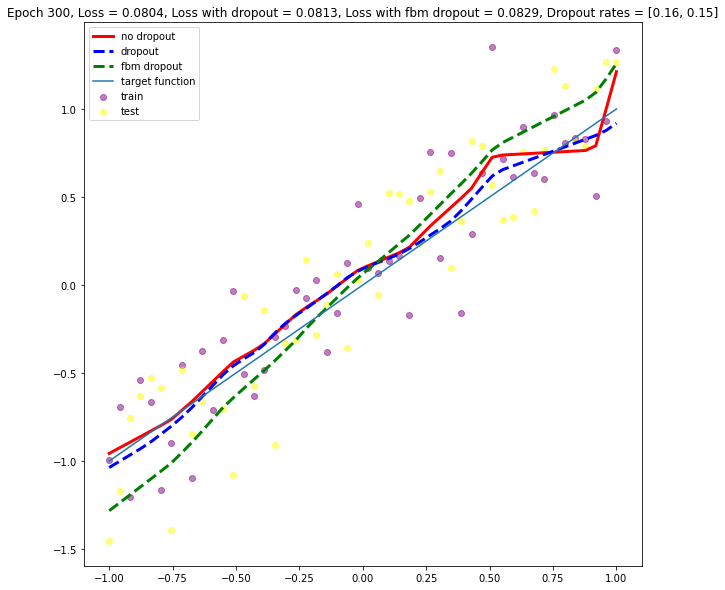

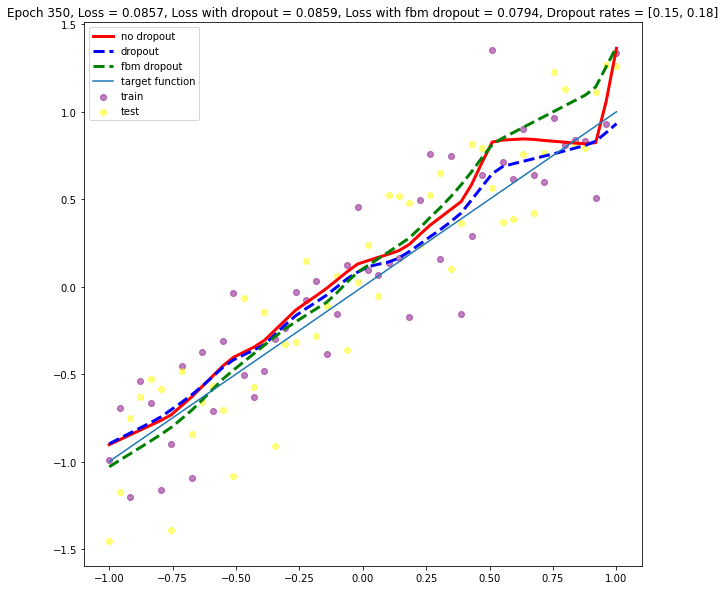

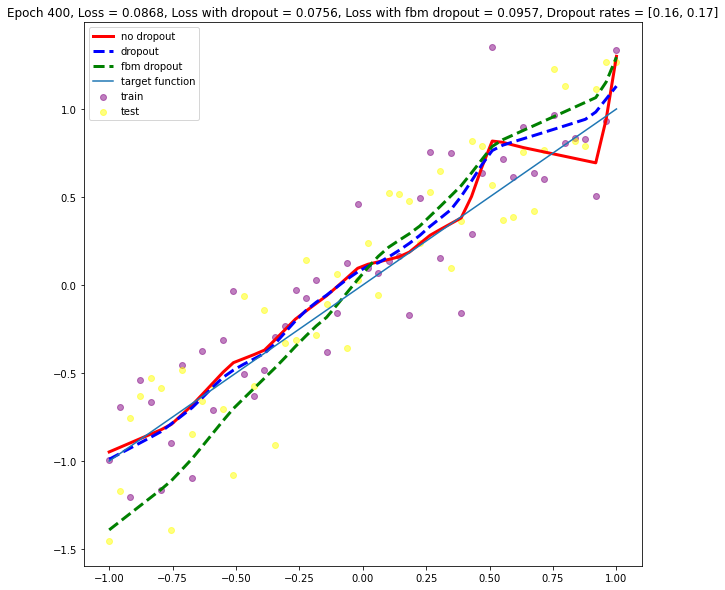

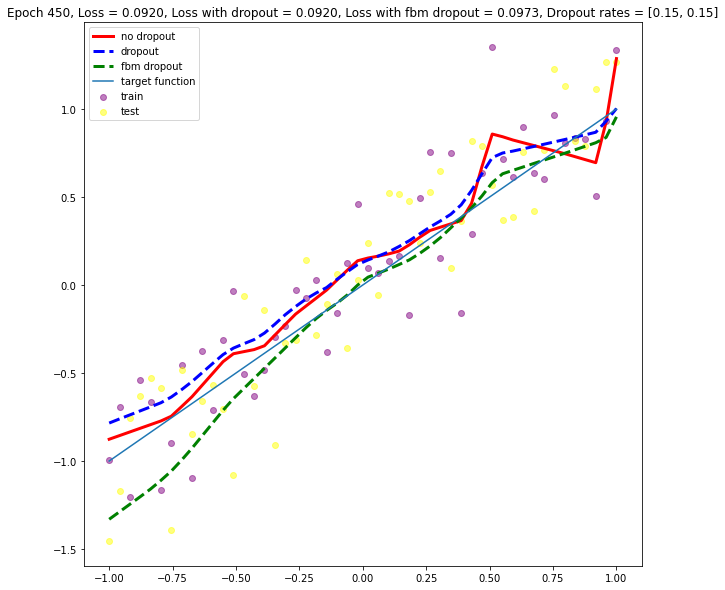

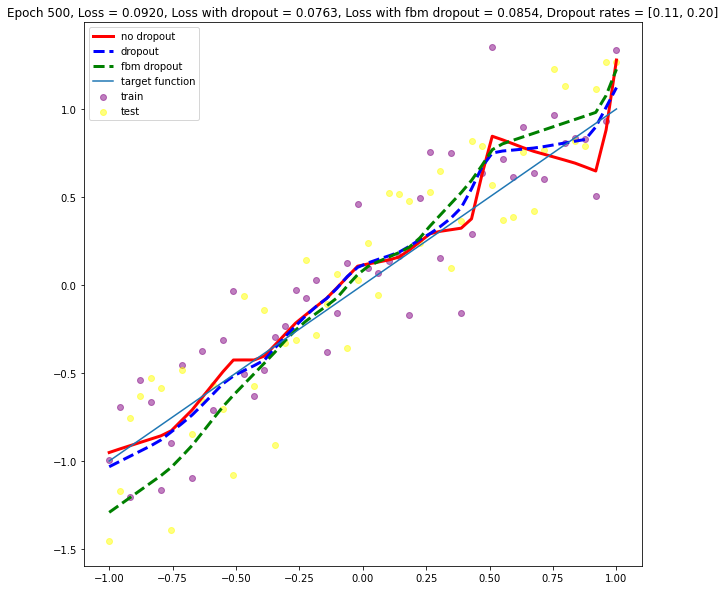

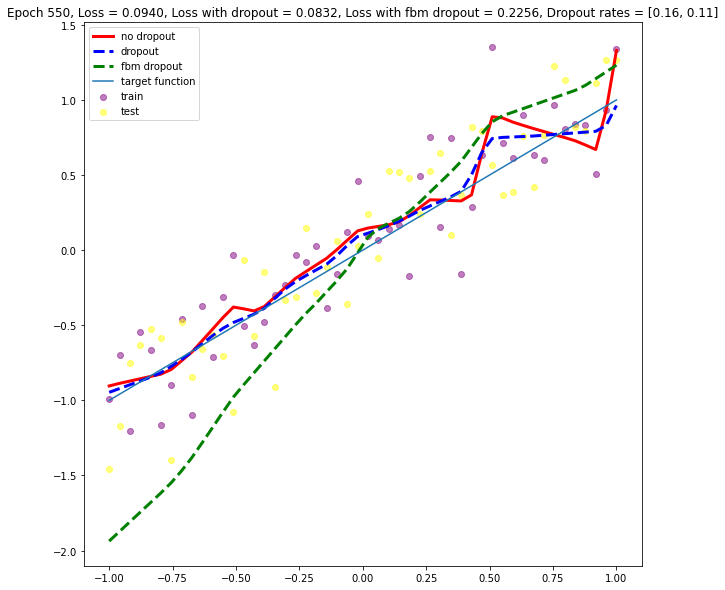

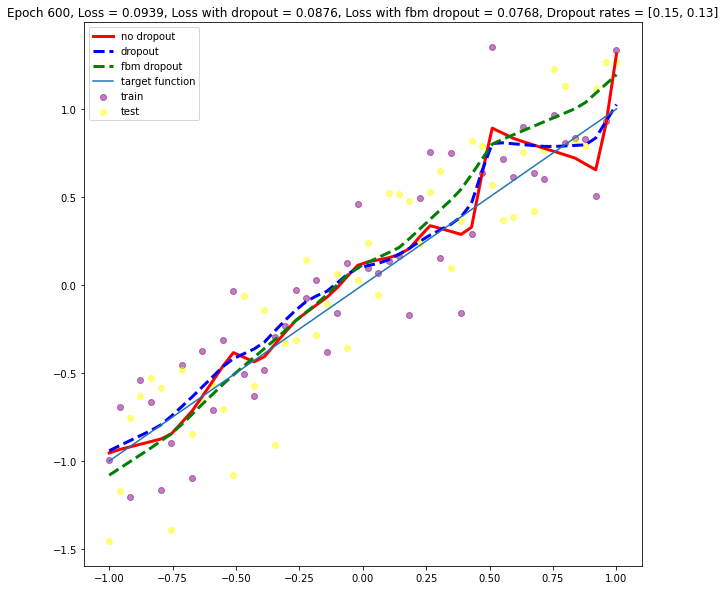

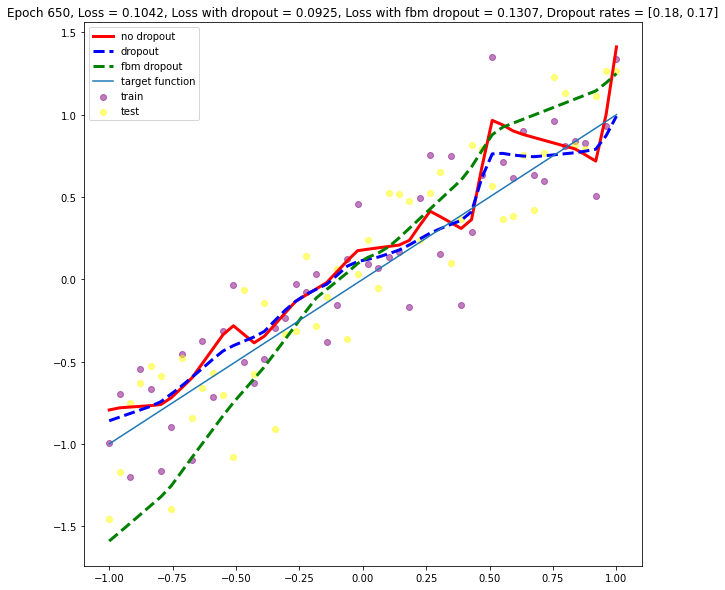

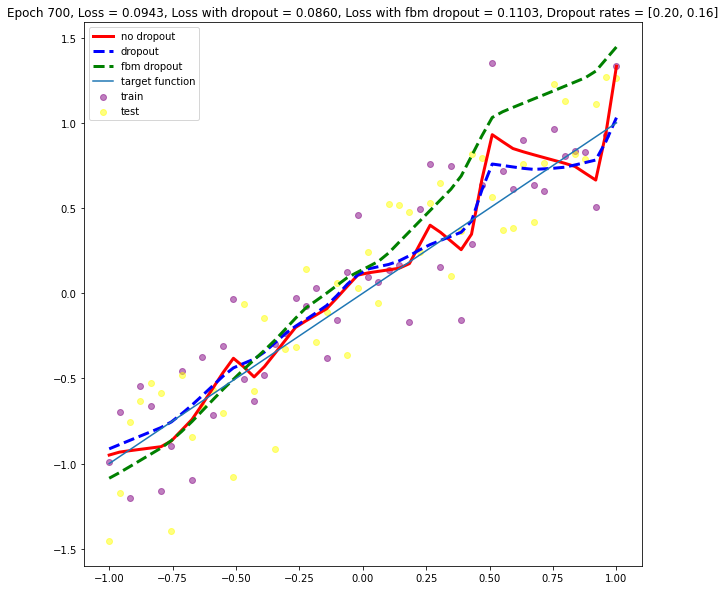

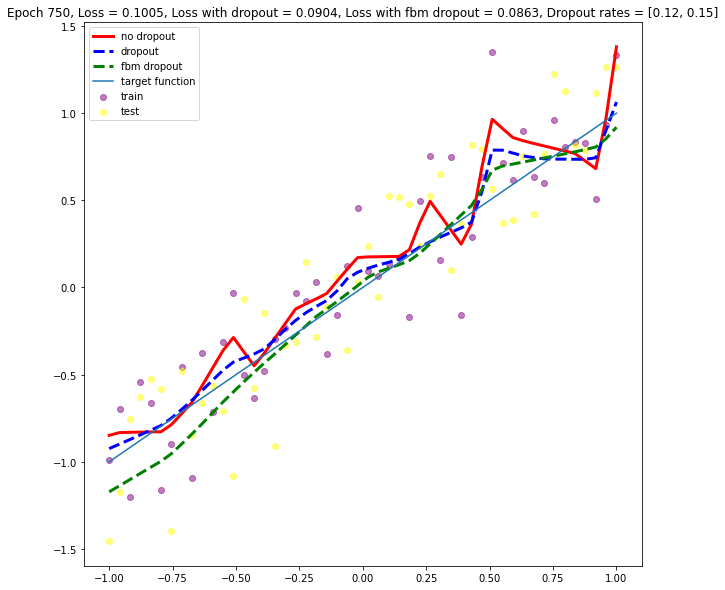

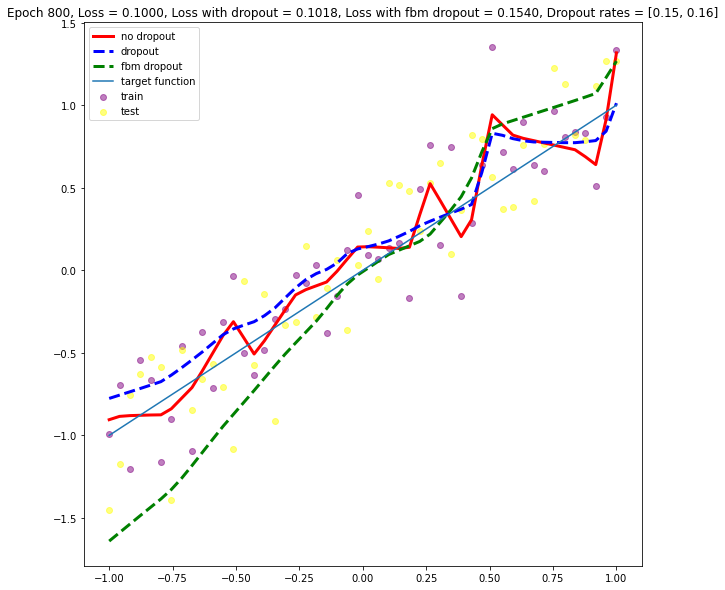

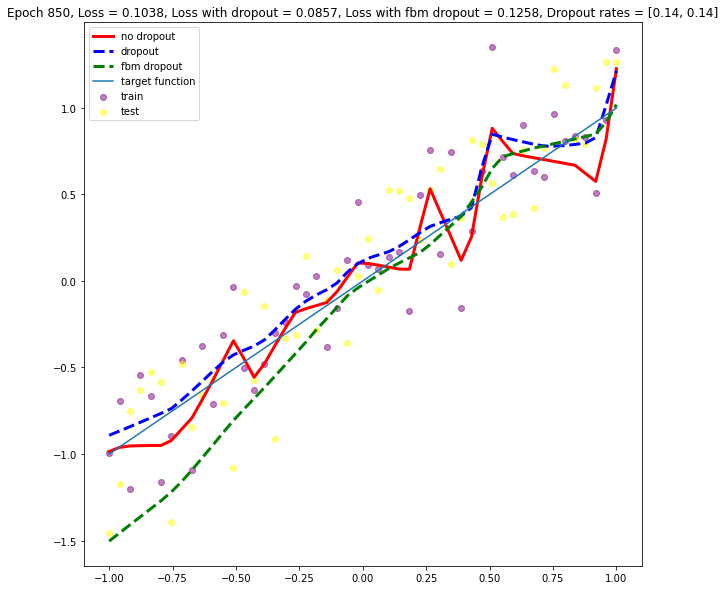

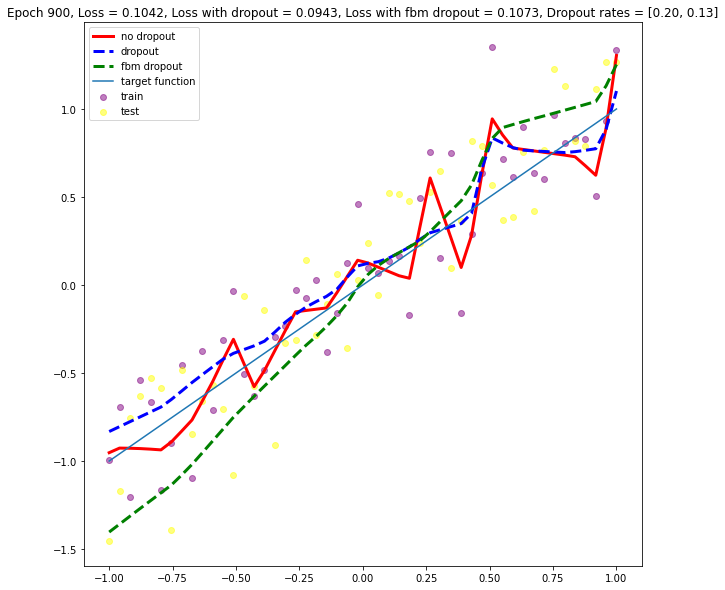

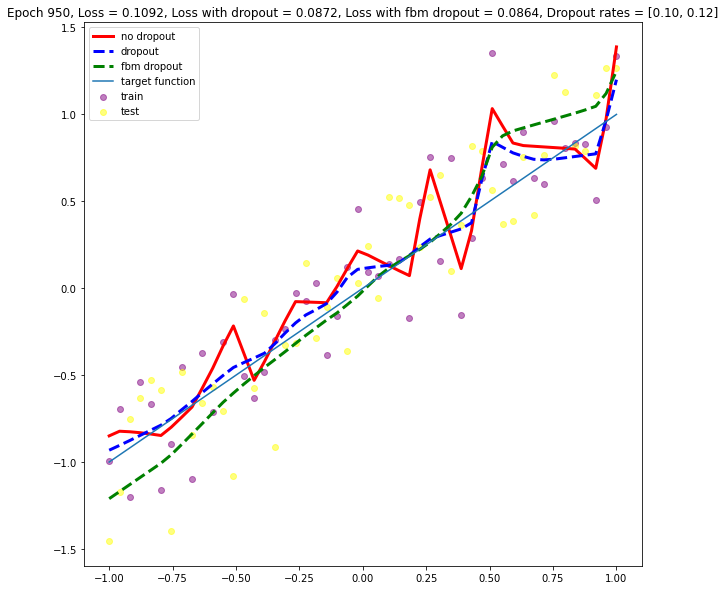

Dropout rates = [0.15, 0.15]


In [12]:
total_dr_1 = total_dr_2 = 0.0

for epoch in range(max_epochs):
    
    pred = no_dropout_model(X_train) # look at the entire data in a single shot
    loss = loss_fn(pred, Y_train)
    no_dropout_opt.zero_grad()
    loss.backward()
    no_dropout_opt.step()
    
    pred_dropout = with_dropout_model(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    with_dropout_opt.zero_grad()
    loss_dropout.backward()
    with_dropout_opt.step()

    pred_fbm_dropout = with_fbm_dropout_model(X_train, epoch)
    loss_fbm_dropout = loss_fn(pred_fbm_dropout, Y_train)
    with_fbm_dropout_opt.zero_grad()
    loss_fbm_dropout.backward()
    with_fbm_dropout_opt.step()
    
    dr1 = with_fbm_dropout_model.dropout_1.get_dropout_rate()
    dr2 = with_fbm_dropout_model.dropout_2.get_dropout_rate()

    total_dr_1 += dr1
    total_dr_2 += dr2

    if epoch % 50 == 0:
        
        no_dropout_model.eval()
        with_dropout_model.eval()
        with_fbm_dropout_model.eval()
        
        test_pred = no_dropout_model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = with_dropout_model(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

        test_pred_fbm_dropout = with_fbm_dropout_model(X_test, epoch)
        test_loss_fbm_dropout = loss_fn(test_pred_fbm_dropout, Y_test)
        
        plt.figure(figsize=(10,10))
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='no dropout')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        plt.plot(X_test.data.numpy(), test_pred_fbm_dropout.data.numpy(), 'g--', lw=3,  label='fbm dropout')
        plt.plot(X_test.data.numpy(), X_test.data.numpy(), label='target function')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f, Loss with fbm dropout = %0.4f, Dropout rates = [%0.2f, %0.2f]' % (epoch, test_loss, test_loss_dropout, test_loss_fbm_dropout, dr1, dr2))
        
        plt.legend()

        no_dropout_model.train()
        with_dropout_model.train()
        with_fbm_dropout_model.train()
        
        plt.pause(0.05)

total_dr_1 /= max_epochs
total_dr_2 /= max_epochs

print('Dropout rates = [{:.2}, {:.2}]'.format(total_dr_1, total_dr_2))